<a href="https://colab.research.google.com/github/ciepielajan/Multi-Class-Classification-NLP/blob/main/Detecting_intentions_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Detecting_intentions_MLP

#### Pobranie danych

In [ ]:
# https://drive.google.com/file/d/1fI6EXyD9TMTC1jzdu206ljXOGNjdHprq/view?usp=sharing
!gdown --id "1fI6EXyD9TMTC1jzdu206ljXOGNjdHprq"

Downloading...
From: https://drive.google.com/uc?id=1fI6EXyD9TMTC1jzdu206ljXOGNjdHprq
To: /content/user_intent.zip
100% 271k/271k [00:00<00:00, 35.0MB/s]


In [ ]:
!unzip "user_intent.zip"

Archive:  user_intent.zip
  inflating: train.csv               
  inflating: __MACOSX/._train.csv    
  inflating: validation.csv          


In [ ]:
import pandas as pd
import numpy as np

data_set_train = pd.read_csv("train.csv")
data_set_valid = pd.read_csv("validation.csv")

print(data_set_train.shape)
print(data_set_valid.shape)

print(data_set_train.columns)
print(data_set_valid.columns)

(13784, 2)
(700, 2)
Index(['text', 'label'], dtype='object')
Index(['text', 'label'], dtype='object')


#### Podstawowy process text

In [ ]:
import re
def process_text(sentence):
    sentence = re.sub('[A-Za-z0-9]+@[a-zA-z].[a-zA-Z]+', '', sentence)  # maile
    sentence = re.sub('(http[s]*:[/][/])[a-zA-Z0-9]+', '', sentence)  # linki
    sentence = re.sub(r"<[^>]+>", " ", sentence) # remove html tag
    sentence = re.sub(r"[^a-zA-Z\s]", "", sentence)  # remove punctuations and numbers   
    sentence = re.sub(r"\b[A-Za-z]{1}\b", "", sentence)  # remove single characters

    sentence = re.sub("^\s+|\s+$", "", sentence, flags=re.UNICODE) # Remove spaces both in the BEGINNING and in the END of a string:
    sentence = " ".join(re.split("\s+", sentence, flags=re.UNICODE))  # Remove ONLY DUPLICATE spaces:
    sentence = sentence.lower()
    
    return sentence

In [ ]:
data_set_train["clean_text"] = data_set_train["text"].apply(lambda x: process_text(x))

#### `LabelEncoder` oraz `to_categorical`

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical 


labelencoder = LabelEncoder()
labelencoder.fit(data_set_train["label"])

data_set_train["labelencoder"] = labelencoder.transform(data_set_train["label"])

dummy_y = to_categorical(data_set_train["labelencoder"], dtype ="float32")

data_set_train[["clean_text","label","labelencoder"]].head(5)

,clean_text,label,labelencoder
0,find cinema nearest for films,SearchScreeningEvent,6
1,give the current series two stars,RateBook,4
2,find the good girl at movie house,SearchScreeningEvent,6
3,please make reservations for three at kosher t...,BookRestaurant,1
4,what is the forecast for here one second from now,GetWeather,2


In [ ]:
dummy_y.shape

(13784, 7)

In [ ]:
id_intention = 4
print("Sprawdzenie poprawności LabelEncoder i to_categorical \n")
print("Label - ", data_set_train["label"].iloc[id_intention])
print("LabelEncoder - ", data_set_train["labelencoder"].iloc[id_intention])
print()
print("to_categorical - ", dummy_y[id_intention])
print()
print("return to LabelEncoder - ",np.argmax(dummy_y[id_intention], axis=-1))
print("return to Label - ",labelencoder.inverse_transform([np.argmax(dummy_y[id_intention], axis=-1)]))

Sprawdzenie poprawności LabelEncoder i to_categorical 

Label -  GetWeather
LabelEncoder -  2

to_categorical -  [0. 0. 1. 0. 0. 0. 0.]

return to LabelEncoder -  2
return to Label -  ['GetWeather']


#### Zdefiniowanie X i y

In [ ]:
X = data_set_train["clean_text"]
y = dummy_y

In [ ]:
X.shape, y.shape

((13784,), (13784, 7))

#### Podział zbioru 

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11027,), (2757,), (11027, 7), (2757, 7))

#### `Tokenizer` i `pad_sequences`

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

maxlen = 7
vocab_size = len(tokenizer.word_index) + 1

X_train = pad_sequences(X_train, padding="post", truncating="post", maxlen=maxlen)
X_test = pad_sequences(X_test, padding="post", truncating="post", maxlen=maxlen)

#### Model

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, SimpleRNN, Dense
from keras.layers.embeddings import Embedding
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=maxlen))  
model.add(Flatten())
model.add(Dense(7, activation="softmax")) # sigmoid / softmax
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 7, 100)            976800    
_________________________________________________________________
flatten (Flatten)            (None, 700)               0         
_________________________________________________________________
dense (Dense)                (None, 7)                 4907      
Total params: 981,707
Trainable params: 981,707
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

EarlyStop = EarlyStopping(monitor='val_loss', 
                          patience=5,
                          verbose=1)

history = model.fit(X_train, 
                    y_train, 
                    epochs=20, 
                    batch_size=64, 
                    validation_split=0.2, 
                    callbacks = [EarlyStop] )
scores = model.evaluate(X_test, y_test)
print(f"Accuracy {scores[1] * 100}")

Epoch 1/20
138/138 [==============================] - 3s 19ms/step - loss: 1.5719 - accuracy: 0.6944 - val_loss: 0.3967 - val_accuracy: 0.9420
Epoch 2/20
138/138 [==============================] - 2s 15ms/step - loss: 0.2917 - accuracy: 0.9525 - val_loss: 0.1612 - val_accuracy: 0.9637
Epoch 3/20
138/138 [==============================] - 2s 15ms/step - loss: 0.1123 - accuracy: 0.9803 - val_loss: 0.1116 - val_accuracy: 0.9719
Epoch 4/20
138/138 [==============================] - 2s 15ms/step - loss: 0.0628 - accuracy: 0.9891 - val_loss: 0.0920 - val_accuracy: 0.9742
Epoch 5/20
138/138 [==============================] - 2s 15ms/step - loss: 0.0420 - accuracy: 0.9934 - val_loss: 0.0821 - val_accuracy: 0.9751
Epoch 6/20
138/138 [==============================] - 2s 14ms/step - loss: 0.0283 - accuracy: 0.9945 - val_loss: 0.0766 - val_accuracy: 0.9773
Epoch 7/20
138/138 [==============================] - 2s 15ms/step - loss: 0.0203 - accuracy: 0.9976 - val_loss: 0.0731 - val_accuracy: 0.9787

#### save all files for develop

In [ ]:
import pickle
from keras.models import load_model
from datetime import datetime 

In [ ]:
now = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

In [ ]:
#save and del model 
model.save(f'MLP_develop_model_{now}.h5')  # creates a HDF5 file 'my_model.h5'

In [ ]:
MLP_develop = {
    "tokenizer" :  tokenizer ,
    "maxlen" :  maxlen ,
    "labelencoder" :  labelencoder 
}

In [ ]:
pickle.dump(MLP_develop, open(f"MLP_develop_config_{now}.pickle", "wb"))

#### Predykcja na zbiorze validacyjnym

In [ ]:
# oczysczenie danych
data_set_valid["clean_text"] = data_set_valid["text"].apply(lambda x: process_text(x))

# labelencoder 
data_set_valid["labelencoder"] = labelencoder.fit_transform(data_set_valid["label"])

# tokenizacja weg przetrenowanego już tokenizera
X_validate = tokenizer.texts_to_sequences(data_set_valid["clean_text"])

# pad sequel
X_validate = pad_sequences(X_validate, padding="post", truncating="post", maxlen=maxlen)
X_validate

array([[  15,   42,   50, ...,   44,    6,    1],
       [ 241,  177,   21, ..., 1593,    3,  738],
       [  15,    8,    1, ...,   36,    4,   48],
       ...,
       [  28,    1,   84, ...,   38,    0,    0],
       [  15,    8,    1, ...,   36,    4, 2688],
       [  45,   40,    4, ...,  152,  129,  404]], dtype=int32)

In [ ]:
dummy_y_valid = data_set_valid["labelencoder"].values
dummy_y_valid[:5]

array([6, 3, 2, 0, 6])

In [ ]:
# Sprawdzenie rozmiaru zbiorów validacyjnego
X_validate.shape, dummy_y_valid.shape

((700, 7), (700,))

In [ ]:
predicted_lstm_val = np.argmax(model.predict(X_validate), axis=-1)
predicted_lstm_val[:5]

array([6, 3, 2, 0, 6])

#### Rozkodowanie przewidzianych i prawidłowych etykiet

In [ ]:
y_pred = labelencoder.inverse_transform(predicted_lstm_val)
y_pred = pd.Series(y_pred)
y_pred.head()

0    SearchScreeningEvent
1               PlayMusic
2              GetWeather
3           AddToPlaylist
4    SearchScreeningEvent
dtype: object

In [ ]:
y_val = labelencoder.inverse_transform(dummy_y_valid)
y_val = pd.Series(y_val)
y_val.head()

0    SearchScreeningEvent
1               PlayMusic
2              GetWeather
3           AddToPlaylist
4    SearchScreeningEvent
dtype: object

#### `Confusion matrix`

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

Accuracy: 0.97
F1_score: 0.97
                      precision    recall  f1-score   support

       AddToPlaylist       0.98      0.99      0.99       100
      BookRestaurant       0.99      0.98      0.98       100
          GetWeather       0.96      0.96      0.96       100
           PlayMusic       0.99      0.97      0.98       100
            RateBook       1.00      1.00      1.00       100
  SearchCreativeWork       0.91      1.00      0.95       100
SearchScreeningEvent       0.99      0.91      0.95       100

            accuracy                           0.97       700
           macro avg       0.97      0.97      0.97       700
        weighted avg       0.97      0.97      0.97       700



(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <a list of 7 Text major ticklabel objects>)

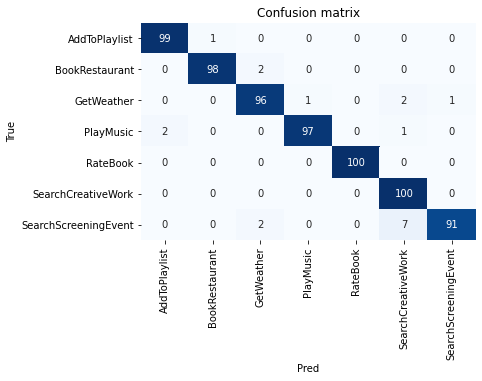

In [ ]:
classes = np.unique(y_val)

print('Accuracy:', round(accuracy_score(y_val, y_pred),2))
print('F1_score:', round(f1_score(y_val, y_pred, average='weighted'),2))

print(classification_report(y_val, y_pred))
# Plot confusion matrix
cm = confusion_matrix(y_val, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel='Pred', ylabel='True', xticklabels=classes, yticklabels=classes, title='Confusion matrix')
plt.yticks(rotation=0)
plt.xticks(rotation=90)

#### Zapoznanie się z błędnymi predykcjami 

In [ ]:
indexes = []
for i, phrase in enumerate(y_pred):
  if phrase == 'SearchCreativeWork':
    if y_val[i] == 'SearchScreeningEvent':
      indexes.append(i)
print(indexes)

[6, 346, 519, 557, 615, 648, 689]


In [ ]:
" ".join(data_set_valid['clean_text'][568].split()[:maxlen+1])

'can you check the timings for super sweet'

In [ ]:
for i in indexes:
  print(f"----------------------------\nTekst komendy id {i}:\n{data_set_valid['text'][i]}")
  print(f"Oczyszczona komenda i skrócona do wartości maxlen={maxlen}:\n{' '.join(data_set_valid['clean_text'][i].split()[:maxlen])}")
  print(f'True category: {y_val[i]}')
  print(f'Predicted category: {y_pred[i]}')
  print("\n")

----------------------------
Tekst komendy id 6:
I want to see While the Sun Shines at the closest movie house.
Oczyszczona komenda i skrócona do wartości maxlen=7:
want to see while the sun shines
True category: SearchScreeningEvent
Predicted category: SearchCreativeWork


----------------------------
Tekst komendy id 346:
I want to see Those Kids from Town, when will it be showing?
Oczyszczona komenda i skrócona do wartości maxlen=7:
want to see those kids from town
True category: SearchScreeningEvent
Predicted category: SearchCreativeWork


----------------------------
Tekst komendy id 519:
i want to see JLA Adventures: Trapped In Time
Oczyszczona komenda i skrócona do wartości maxlen=7:
want to see jla adventures trapped in
True category: SearchScreeningEvent
Predicted category: SearchCreativeWork


----------------------------
Tekst komendy id 557:
I want to see Shattered Image.
Oczyszczona komenda i skrócona do wartości maxlen=7:
want to see shattered image
True category: SearchS

Wnioski:
> Model ma tendencję do faworyzowania etykiety SearchCreativeWork kosztem SearchScreeningEvent. Świadczy o tym `100% skutczeność predykcji SearchCreativeWork` przy `91% skuteczności predykcji SearchScreeningEvent`. Może to wynikać z przeuczenia modelu. 

> Błędne predykcje zawieraja takie słowa jak `want` i `see` może lemmatyzacja lub usunięcie stop wrordów poprawi wynik. 

> Istotne dla skuteczności modelu może być wartość parametru `maxlen` odpowiadającego za długość intencji która trafia do modelu. W obecnym przykładzie  załóżyłem `maxlen=7` czyli model analizuje tylko pierwsze 7 słów. Warto sprawdzić wyniki dla maxlen równe 7,15 i 30. 

REAL PREDICT

#### loading the necessary files to predict in develop

In [3]:
# model
# https://drive.google.com/file/d/1LQzf7_SBpmee41X7ecupKFMGb8n9LXLk/view?usp=sharing
!gdown --id "1LQzf7_SBpmee41X7ecupKFMGb8n9LXLk" -O "develop_model.h5"

# config
# https://drive.google.com/file/d/11JehTWT6J_oHyVBAcdZtq8PRJ50pRKRz/view?usp=sharing
!gdown --id "11JehTWT6J_oHyVBAcdZtq8PRJ50pRKRz"  -O "develop_config.pickle"

Downloading...
From: https://drive.google.com/uc?id=1LQzf7_SBpmee41X7ecupKFMGb8n9LXLk
To: /content/develop_model.h5
11.8MB [00:00, 37.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=11JehTWT6J_oHyVBAcdZtq8PRJ50pRKRz
To: /content/develop_config.pickle
100% 451k/451k [00:00<00:00, 63.7MB/s]


In [ ]:
# - LOAD
# - function process_text
# - instancje tokenizera
# - maxlen dla pad_sequences
# - model
# - instancje labelencoder - do odkodowania predykcji

In [4]:
from keras.models import load_model
model = load_model('develop_model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 7, 100)            976800    
_________________________________________________________________
flatten (Flatten)            (None, 700)               0         
_________________________________________________________________
dense (Dense)                (None, 7)                 4907      
Total params: 981,707
Trainable params: 981,707
Non-trainable params: 0
_________________________________________________________________


In [21]:
import pickle
with open('develop_config.pickle', 'rb') as f:
  develop_config = pickle.load(f)

develop_config

{'labelencoder': LabelEncoder(),
 'maxlen': 7,
 'tokenizer': <keras_preprocessing.text.Tokenizer at 0x7fb0042ab750>}

In [22]:
labelencoder = develop_config["labelencoder"]
maxlen = develop_config["maxlen"]
tokenizer = develop_config["tokenizer"]

#### Predict

In [ ]:
import re
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [41]:
# x = "PLAY <dasf>M</html> my 32 favorite music"
# x = "find my favorite book"
# x = "check the 'Red Hot Chili Peppers' discography"
# x = "play the 'Red Hot Chili Peppers' discography"
x = "play  'Red Hot Chili Peppers'"


In [42]:
def process_text(sentence):
    sentence = re.sub('[A-Za-z0-9]+@[a-zA-z].[a-zA-Z]+', '', sentence)  # maile
    sentence = re.sub('(http[s]*:[/][/])[a-zA-Z0-9]+', '', sentence)  # linki
    sentence = re.sub(r"<[^>]+>", " ", sentence) # remove html tag
    sentence = re.sub(r"[^a-zA-Z\s]", "", sentence)  # remove punctuations and numbers   
    sentence = re.sub(r"\b[A-Za-z]{1}\b", "", sentence)  # remove single characters

    sentence = re.sub("^\s+|\s+$", "", sentence, flags=re.UNICODE) # Remove spaces both in the BEGINNING and in the END of a string:
    sentence = " ".join(re.split("\s+", sentence, flags=re.UNICODE))  # Remove ONLY DUPLICATE spaces:
    sentence = sentence.lower()
    
    return sentence

In [43]:
x = process_text(x)
x = tokenizer.texts_to_sequences([x])
x = pad_sequences(x, padding="post", truncating="post", maxlen=maxlen)
predicted_lstm_val = np.argmax(model.predict(x), axis=-1)
y_pred = labelencoder.inverse_transform(predicted_lstm_val)[0]
y_pred

'PlayMusic'

In [44]:
# wszysktie etykiety
labelencoder.classes_.tolist()

['AddToPlaylist',
 'BookRestaurant',
 'GetWeather',
 'PlayMusic',
 'RateBook',
 'SearchCreativeWork',
 'SearchScreeningEvent']